# System analysis

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

### 1) Load data from BIN files

In [2]:
### Load data from disk
import pickle
with open('aida_agdistis.bin', 'rb') as outfile:
    aida_agd_articles=pickle.load(outfile)
with open('wes2015_agdistis.bin', 'rb') as outfile:
    wes_agd_articles=pickle.load(outfile)
with open('aida_spotlight.bin', 'rb') as outfile:
    aida_spot_articles=pickle.load(outfile)
with open('wes2015_spotlight.bin', 'rb') as outfile:
    wes_spot_articles=pickle.load(outfile)
    
wes_title='wes2015'
aida_title='aida'

#### DEBUG: Store agdistis output to a file

In [3]:

with open('agdmag_aida_debug.tsv', 'w') as w:
    w.write('collection\tarticle_ID\tbegin_index\tend_index\tmention\tgold_link\tsystem_link\n')
    for article in aida_agd_articles:
        for mention in article.entity_mentions:
            if mention.sys_link.startswith('http://aksw.org/'):
                mention.sys_link = '--NME--'

            a_row=[article.collection, str(article.identifier), 
                   str(mention.begin_index), str(mention.end_index), 
                   mention.mention, mention.gold_link, 
                   mention.sys_link]
            w.write('\t'.join(a_row) + '\n')

In [4]:
import utils
import plot_utils
import time
from collections import defaultdict

**1.1. Pick dataset**

In [5]:
print(type(aida_agd_articles))
spot_articles=aida_spot_articles.union(wes_spot_articles)
agd_articles=aida_agd_articles.union(wes_agd_articles)
#print(len(articles))


<class 'set'>


In [6]:
for article in wes_agd_articles:
    for mention in article.entity_mentions:
        print(mention.sys_link)

November_9
http://aksw.org/notInWiki/1884
Switzerland
Royal_College_of_Psychiatrists
http://aksw.org/notInWiki/psychoanalyst
Hermann_Rorschach
Rorschach_test
Hermann_Rorschach
Zürich
Visual_arts_education
Hermann_Rorschach
Zürich
Hermann_Rorschach
Visual_arts_education
Hermann_Rorschach
Ernst_Haeckel
Hermann_Rorschach
Visual_arts_education
Hermann_Rorschach
Neuchâtel
http://aksw.org/notInWiki/1904
Country_rock_(geology)
Botany_Boyz
French_(surname)
University_of_Bern
Medicine_(band)
Scientific_Research_Publishing
Berlin
Nuremberg
Hermann_Rorschach
Scientific_Research_Publishing
Combination_lock
http://aksw.org/notInWiki/JustinusKerner
P/B_ratio
List_of_poetry_collections
http://aksw.org/notInWiki/1857
http://aksw.org/notInWiki/poem
Alfred_Binet
Rorschach_test
Creativity_techniques
Hermann_Rorschach
http://aksw.org/notInWiki/patients
http://aksw.org/notInWiki/differentthings
http://aksw.org/notInWiki/experiments
Rorschach_test
Schizophrenia_(object-oriented_programming)
http://aksw.org/

http://aksw.org/notInWiki/canalinPanama
http://aksw.org/notInWiki/1879
Congress
Paris
Panama_Canal
Mathieu_de_Lesseps
Panama_Canal
Malaria!
Yellow_Fever_(play)
http://aksw.org/notInWiki/December
http://aksw.org/notInWiki/1888
Liquidationism
http://aksw.org/notInWiki/February
http://aksw.org/notInWiki/1889
http://aksw.org/notInWiki/Frenchpoliticians
http://aksw.org/notInWiki/journalists
Mathieu_de_Lesseps
Mathieu_de_Lesseps
Ferdinand_de_Lesseps
http://aksw.org/notInWiki/7December
http://aksw.org/notInWiki/1894
June_3_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1965
Edward_Higgins_White
http://aksw.org/notInWiki/Gemini4
White's
United_States_Military_Academy
Gus_Grissom
Roger_B._Chaffee
Cape_Canaveral,_Florida
Edward_White_(composer)
http://aksw.org/notInWiki/Bachelordegree
United_States_Military_Academy
Ginger_Baker's_Air_Force
West_Germany
NATO
White's
http://aksw.org/notInWiki/aeronauticalengineering
http://aksw.org/notInWiki/1958
University_of_Michigan
Ginger_Baker's_Air_F

COBOL_ReSource
http://aksw.org/notInWiki/naturalhumanlanguage
Grace_Hopper
Computer_Sciences_Corporation
Computer_Sciences_Corporation
http://aksw.org/notInWiki/1969
http://aksw.org/notInWiki/NationalMedalofTechnology
http://aksw.org/notInWiki/1991
Woman_(UK_magazine)
http://aksw.org/notInWiki/nobelprize
http://aksw.org/notInWiki/EudoxusofCnidus
Greek_to_me
Astronomer_(comics)
http://aksw.org/notInWiki/mathematician
http://aksw.org/notInWiki/Plato
Method_of_exhaustion
http://aksw.org/notInWiki/integralcalculus
http://aksw.org/notInWiki/EudoxusofCnidus
http://aksw.org/notInWiki/408BC
Eudoxus_(Martian_crater)
http://aksw.org/notInWiki/DiogenesLaërtius
Eudoxus_(Martian_crater)
Italy
Archytas
Pythagoras
Mathematics_(producer)
Eudoxus_(Martian_crater)
Sicily
Medicine_(band)
Athens
http://aksw.org/notInWiki/387BC
Eudoxus_(Martian_crater)
http://aksw.org/notInWiki/month
Athens
Philosophy_(journal)
http://aksw.org/notInWiki/Plato
Eudoxus_(Martian_crater)
Piraeus
http://aksw.org/notInWiki/Plato

Jacques_Boucher_de_Crèvecœur_de_Perthes
Robertson_Davies
http://aksw.org/notInWiki/1847
Issues_(band)
http://aksw.org/notInWiki/threevolume
Discovery_of_human_antiquity
http://aksw.org/notInWiki/Pleistocene
http://aksw.org/notInWiki/Quaternaryperiod
http://aksw.org/notInWiki/views
Approval_proofer
Theory
Discovery_of_human_antiquity
Fact
http://aksw.org/notInWiki/figures
P/B_ratio
Plan_(drawing)
Flint
http://aksw.org/notInWiki/sign
Joy_Electric
Jacques_Boucher_de_Crèvecœur_de_Perthes
Hand_axe
http://aksw.org/notInWiki/objects
Fragments_(magazine)
http://aksw.org/notInWiki/items
http://aksw.org/notInWiki/tools
http://aksw.org/notInWiki/tools
Hobby
http://aksw.org/notInWiki/archaeologist
Bones_(band)
Lists_of_extinct_animals
Jacques_Boucher_de_Crèvecœur_de_Perthes
http://aksw.org/notInWiki/tools
Lists_of_extinct_animals
Evidence
The_Mind_of_Primitive_Man
Charles_Lyell
Jacques_Boucher_de_Crèvecœur_de_Perthes
Royal_Society
Finding
Customs_officer
Interest_rate
Eduard_Study
Theory
http://ak

http://aksw.org/notInWiki/clergyman
http://aksw.org/notInWiki/1820
Miles_(band)
Haworth
Charlotte_Brontë
The_Mothers_of_Invention
Cancer_(band)
http://aksw.org/notInWiki/1821
http://aksw.org/notInWiki/fivedaughters
Maria_(Danish_singer)
Elizabeth_Branwell
Charlotte_Brontë
Emily_Brontë
Anne_Hutchinson
Bush_ballad
Elizabeth_Branwell
Career
http://aksw.org/notInWiki/sister
Elizabeth_Branwell
http://aksw.org/notInWiki/Afterthedeaths
http://aksw.org/notInWiki/sisters
Maria_(Danish_singer)
Elizabeth_Branwell
http://aksw.org/notInWiki/tuberculosis
http://aksw.org/notInWiki/1825
Charlotte_Brontë
Backyard_Babies
Guardian_(band)
http://aksw.org/notInWiki/heryoungersisters
Sibling
Elizabeth_Branwell
Emily_Brontë
Anne_Hutchinson
http://aksw.org/notInWiki/fictionalworlds
Lincolnshire_Integrated_Voluntary_Emergency_Service
Residency_(domicile)
http://aksw.org/notInWiki/imaginarykingdoms
http://aksw.org/notInWiki/1831
http://aksw.org/notInWiki/1832
Charlotte_Brontë
Generic_top-level_domain
Roe
Body/H

http://aksw.org/notInWiki/WorldWarII
http://aksw.org/notInWiki/radiooperator
Europe
Japanese_naval_codes
http://aksw.org/notInWiki/U.S
http://aksw.org/notInWiki/ElectricalEngineering
University_of_Minnesota
Graduation
http://aksw.org/notInWiki/1949
http://aksw.org/notInWiki/appliedmathematics
http://aksw.org/notInWiki/1951
http://aksw.org/notInWiki/1950
Cray-4
Engineering_Research_Associates
UNIVAC_1103
Saint_Paul,_Minnesota
UNIVAC_1103
United_States_Navy
http://aksw.org/notInWiki/code
Cyberman_(audio_drama_series)
Tradition_(band)
UNIVAC_1103
UNIVAC_1103
http://aksw.org/notInWiki/computertechnology
Engineering_(constituency)
Cray-4
Expert
http://aksw.org/notInWiki/computertechnology
Milner_Gray_(designer)
UNIVAC_1103
http://aksw.org/notInWiki/scientificcomputer
UNIVAC_1103
Remington_Rand
Sperry_Corporation
http://aksw.org/notInWiki/1950s
Sperry_Corporation
UNIVAC_1103
http://aksw.org/notInWiki/scientificcomputing
UNIVAC
http://aksw.org/notInWiki/1957
http://aksw.org/notInWiki/employee

Medicine_(band)
Human_error_assessment_and_reduction_technique
http://aksw.org/notInWiki/syphilis
Andrea_Cesalpino
http://aksw.org/notInWiki/bloodcirculation
Human_error_assessment_and_reduction_technique
http://aksw.org/notInWiki/circulationoftheblood
Botany_Boyz
Andrea_Cesalpino
http://aksw.org/notInWiki/1583
Andrea_Cesalpino
Botany_Boyz
Andrea_Cesalpino
Botanist_(band)
Aristotle
http://aksw.org/notInWiki/biologicalclassification
Theophrastus
History_of_plant_systematics
Andrea_Cesalpino
Herbarium
Herbarium
http://aksw.org/notInWiki/MuseumofNaturalHistoryinFlorence
Andrea_Cesalpino
Andrea_Cesalpino
Andrea_Cesalpino
Philosophy_(journal)
Medicine_(band)
Botany_Boyz
http://aksw.org/notInWiki/PisaBotanicgarden
http://aksw.org/notInWiki/1554
http://aksw.org/notInWiki/Ghini
http://aksw.org/notInWiki/1547
http://aksw.org/notInWiki/BotanicGardeninPadua
http://aksw.org/notInWiki/DePlantisLibrisXVI
Philosophy_(journal)
Medicine_(band)
Botany_Boyz
John_Fothergill_(engineer)
March_9
http://aksw.

Medicine_(band)
New_York_University
Henry_Draper
Henry_Draper
Photograph
Nebula_(band)
http://aksw.org/notInWiki/GreatNebulaofOrion
http://aksw.org/notInWiki/1880
http://aksw.org/notInWiki/stellarspectrum
Photograph
Vega
http://aksw.org/notInWiki/1872
Photograph
http://aksw.org/notInWiki/comet's
http://aksw.org/notInWiki/Tebbutt'sComet
http://aksw.org/notInWiki/1881
The_Amateur_Astronomer
Photograph
Moon_(visual_novel)
Sun_(Ceylon)
http://aksw.org/notInWiki/1873
http://aksw.org/notInWiki/OrionNebula
http://aksw.org/notInWiki/observatories
Henry_Draper
New_York_University
University_of_Wisconsin–Madison
Astronomische_Gesellschaft
American_Philosophical_Society
August_26_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1906
American_McGee
Bill_Parker_(inventor)
http://aksw.org/notInWiki/television
Philo_Farnsworth
http://aksw.org/notInWiki/electronictelevision
Philo_Farnsworth
Utah
Idaho
Bill_Parker_(inventor)
Chemistry_(band)
http://aksw.org/notInWiki/Farnsworth
http://aksw.org/no

http://aksw.org/notInWiki/1905
Pasteur_Institute
Brie-Comte-Robert
Paris
http://aksw.org/notInWiki/1940
http://aksw.org/notInWiki/LeonardNimoy
Vassy_(singer)
Science_(journal)
Tribute_(ticket)
The_Hero_Initiative
http://aksw.org/notInWiki/character
http://aksw.org/notInWiki/icon
http://aksw.org/notInWiki/LeonardNimoy
Alter_ego
Spock
Officer
http://aksw.org/notInWiki/thestarship
Recruit_Training_Command,_Great_Lakes,_Illinois
Yesterday_(TV_channel)
Evening_(magazine)
http://aksw.org/notInWiki/LeonardNimoy's
Spock
Darren_Costin
Spock
http://aksw.org/notInWiki/THEhero
Role_model
Reason_(argument)
http://aksw.org/notInWiki/scientist
http://aksw.org/notInWiki/scientist
http://aksw.org/notInWiki/onTV
http://aksw.org/notInWiki/theApollo
http://aksw.org/notInWiki/moon
Yesterday_(TV_channel)
The_Astronauts
Split_Enz
http://aksw.org/notInWiki/suits
http://aksw.org/notInWiki/inspace
The_Astronauts
http://aksw.org/notInWiki/inspace
Ships_(band)
Alan_Dean_Foster
http://aksw.org/notInWiki/theorigina

Geology_(journal)
http://aksw.org/notInWiki/floraandfauna
http://aksw.org/notInWiki/ice
Dell_Latitude
http://aksw.org/notInWiki/months
February_18_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1903
New_Territory,_Texas
Antarctica
Kaiser_Wilhelm_II_Land
Gaussberg
Cape_Town
South_Africa
June_1_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1903
Erich_von_Drygalski
Expeditions_(book)
Turks_and_Caicos_Islands
Germany
Wilhelm_II,_German_Emperor
Gaussberg
Britishness
Kiel
November_(band)
Erich_von_Drygalski
http://aksw.org/notInWiki/theSouthPole
http://aksw.org/notInWiki/scientificpublications
http://aksw.org/notInWiki/1904
Ohad_Benchetrit
Erich_von_Drygalski
http://aksw.org/notInWiki/co-workers
http://aksw.org/notInWiki/1905
http://aksw.org/notInWiki/1931
Volume
http://aksw.org/notInWiki/atlases
http://aksw.org/notInWiki/1906
Chair_Entertainment
Gaza_Strip
Ludwig_Maximilian_University_of_Munich
Mandatory_retirement
http://aksw.org/notInWiki/1935
Royal_Geographical_Society
I

June_3_(Eastern_Orthodox_liturgics)
http://aksw.org/notInWiki/1812
Germán_Vargas_Lleras
Astronomer_(comics)
Johann_Gottfried_Galle
Johann_Gottfried_Galle
Neptune
Astronomer_(comics)
Urbain_Le_Verrier
Johann_Gottfried_Galle
http://aksw.org/notInWiki/Friedrich-Wilhelms-UniversitätBerlin
http://aksw.org/notInWiki/1839
http://aksw.org/notInWiki/1833
Johann_Gottfried_Galle
http://aksw.org/notInWiki/1838
Saturn
http://aksw.org/notInWiki/2December
http://aksw.org/notInWiki/1839
March_6
http://aksw.org/notInWiki/1840
Thesis
Ole_Rømer
http://aksw.org/notInWiki/20October
http://aksw.org/notInWiki/23October
http://aksw.org/notInWiki/1706
Thesis
Urbain_Le_Verrier
Urbain_Le_Verrier
Neptune
Johann_Gottfried_Galle
Heinrich_Louis_d'Arrest
Johann_Gottfried_Galle
Johann_Gottfried_Galle
Neptune
Urbain_Le_Verrier
Neptune
Neptune
Neptune
Johann_Gottfried_Galle
Janus_Films
Urbain_Le_Verrier
http://aksw.org/notInWiki/planetNeptune
http://aksw.org/notInWiki/Romanmythology
Neptune
The_Mavis's
Earth
Greek_to_me

Bill_Parker_(inventor)
William_Murdock
http://aksw.org/notInWiki/coalgas
http://aksw.org/notInWiki/steampower
William_Murdock
Rupert_Murdoch
http://aksw.org/notInWiki/math
Mechanics
Template_Attribute_Language
http://aksw.org/notInWiki/wood
http://aksw.org/notInWiki/Murdock
Bridge_(ward)
http://aksw.org/notInWiki/Murdock
http://aksw.org/notInWiki/experiments
http://aksw.org/notInWiki/coalgas
James_Watt
http://aksw.org/notInWiki/1777
Birmingham
http://aksw.org/notInWiki/Murdock
Cornwall
Boulton_and_Watt
Engine
Boulton_and_Watt
Cornwall
http://aksw.org/notInWiki/Murdock
Engine
http://aksw.org/notInWiki/Murdock
Boulton_and_Watt
Engine
Inventions_(band)
http://aksw.org/notInWiki/employers
Design_by_contract
Inventions_(band)
http://aksw.org/notInWiki/1799
Design_by_contract
Letters_patent
Inventions_(band)
http://aksw.org/notInWiki/1784
Nicolas-Joseph_Cugnot
http://aksw.org/notInWiki/Murdock
http://aksw.org/notInWiki/Murdock's
Redruth
http://aksw.org/notInWiki/1784
http://aksw.org/notInWik

In [7]:
for col_articles in [aida_agd_articles, wes_agd_articles]:
    for article in col_articles:
        for mention in article.entity_mentions:
            if mention.sys_link.startswith('http://aksw.org/'):
                mention.sys_link = '--NME--'
            #a_row=[article.collection, str(article.identifier), 
            #           str(mention.begin_index), str(mention.end_index), 
            #           mention.mention, mention.gold_link, 
            #           mention.sys_link]
            #print('\t'.join(a_row))

### 2) Performance

<span style="background-color:lightgreen">Section 6.1. of the paper</span>

#### 2.1. Overall

In [8]:
scores=[]
systems=['agdistis', 'spotlight']
system_articles = {'agdistis': agd_articles, 'spotlight': spot_articles}

In [9]:
skip_nils=True
skip_nonnils=False
print("AGDISTIS")
agd_acc=plot_utils.overall_performance(agd_articles, skip_nils, skip_nonnils)
scores.append(['overall', 'agdistis', agd_acc])
print(agd_acc)
print()
print("SPOTLIGHT")
spot_acc=plot_utils.overall_performance(spot_articles, skip_nils, skip_nonnils)
print(spot_acc)
scores.append(['overall', 'spotlight', spot_acc])


AGDISTIS
25236 56404
0.4474150769448975

SPOTLIGHT
38180 56404
0.6769023473512517


#### 2.2. Prepare forms subset to evaluate ambiguous forms

In [10]:
def compute_acc_on_selection(arts, forms_set):
    correct=0
    total=0
    for article in arts:
        for entity in article.entity_mentions:
            if entity.mention in forms_set:
                total+=1
                if entity.gold_link==entity.sys_link:
                    correct+=1
    print(correct, total)
    return correct/total

#### 2.3. Only forms that are interpretted as NILs and not-NILs

In [11]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=False)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    nil_nonnil_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            if '--NME--' in interpretations[form]:
                nil_nonnil_forms.add(form)

    nn_f_acc=compute_acc_on_selection(system_articles[system], nil_nonnil_forms)
    print(system, nn_f_acc)
    scores.append(['forms with nils & non-nils', system, nn_f_acc])

1156 3061
agdistis 0.3776543613198301
1413 3061
spotlight 0.4616138516824567


#### 2.4. Only ambiguous forms

In [12]:
for system in systems:
    interpretations, references = plot_utils.get_interpretations_and_references(system_articles[system], skip_nils=True)
    ambiguity={}
    for form,meanings in interpretations.items():
        ambiguity[form]=len(meanings)

    ambiguous_forms=set()
    for form, amb in ambiguity.items():
        if amb>1:
            ambiguous_forms.add(form)

    amb_f_acc=compute_acc_on_selection(system_articles[system], ambiguous_forms)
    print(system, amb_f_acc)
    scores.append(['ambiguous forms', system, amb_f_acc])

5285 14804
agdistis 0.3569981086192921
8660 14804
spotlight 0.584977033234261


In [13]:
scores

[['overall', 'agdistis', 0.4474150769448975],
 ['overall', 'spotlight', 0.6769023473512517],
 ['forms with nils & non-nils', 'agdistis', 0.3776543613198301],
 ['forms with nils & non-nils', 'spotlight', 0.4616138516824567],
 ['ambiguous forms', 'agdistis', 0.3569981086192921],
 ['ambiguous forms', 'spotlight', 0.584977033234261]]

['overall', 'ambiguous forms', 'forms with nils & non-nils']
['agdistis' 'spotlight']
width: 0.19999999999999998
evaluation: overall
0.4474150769448975
0.6769023473512517
evaluation: ambiguous forms
0.3569981086192921
0.584977033234261
evaluation: forms with nils & non-nils
0.3776543613198301
0.4616138516824567


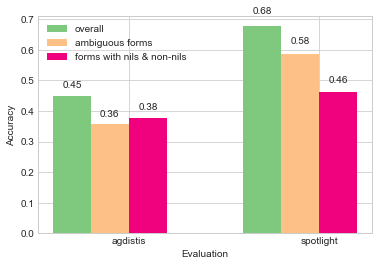

In [15]:
plot_utils.plot_scores(scores, title='Scores of systems')
#plot_scores(scores, title='Scores of systems')

### 3) Correlation between FORM frequency and accuracy

# Note: All stats from here on are on both datasets jointly

<span style="background-color:lightgreen">Section 6.2. of the paper</span>

In [16]:
from scipy.stats import pearsonr, spearmanr

In [17]:
acc_by_form = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_form[system], forms_by_count = plot_utils.compute_accuracy_by_form(
        system_articles[system], skip_nils)

In [18]:
import math

def counts_to_log_counts(forms_by_count):
    forms_by_log_count={}
    for count, forms in forms_by_count.items():
        try:
            log_count=round(math.log(count), 2)
        except:
            print(count)
        forms_by_log_count[log_count] = forms
    return forms_by_log_count

forms_by_log_count=counts_to_log_counts(forms_by_count)

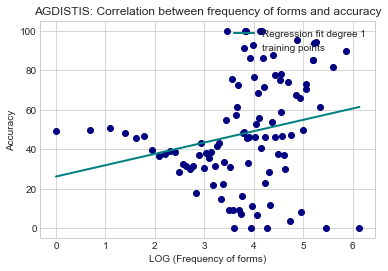

The Spearman correlation between X and Y is: 0.303675699613 . Significance:  0.00213018001308


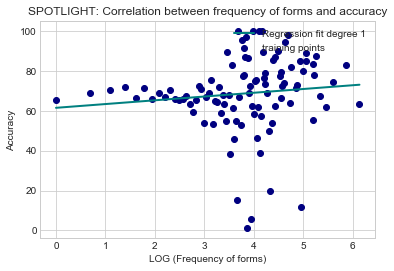

The Spearman correlation between X and Y is: 0.26369907212 . Significance:  0.00802698361416


In [ ]:
from collections import OrderedDict
import numpy as np

acc_by_freq={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(forms_by_log_count.keys()):
        count_forms=forms_by_log_count[count]
        s=0
        for form in count_forms:
            s+=acc_by_form[system][form]
        acc_by_freq[system][count]=s/len(count_forms)
        
        
    dist1=np.array(list(acc_by_freq[system].keys()))
    dist2=np.array(list(acc_by_freq[system].values()))
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of forms and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of forms)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 4) Entropy

In [ ]:
from scipy.stats import entropy
form_entropies={}
for form in ambiguous_forms:
    counts=plot_utils.get_form_counts(spot_articles, form)
    counts=list(counts)
    form_entropies[form]=entropy(counts,base=len(counts))

In [ ]:
for system in systems:
    dist1=[]
    dist2=[]
    for f in ambiguous_forms:
        dist1.append(round(form_entropies[f], 2))
        dist2.append(acc_by_form[system][f])

    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between entropy of ambiguous forms and accuracy' % system.upper(),
                            x_axis='Entropy',
                            y_axis='Accuracy',
                            save=True
                            )

    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)

### 5) Correlation between instance frequency and accuracy

<span style="background-color:lightgreen">Section 6.3. of the paper</span>

In [ ]:
acc_by_uri = {'agdistis': defaultdict(float), 'spotlight': defaultdict(float)}
for system in systems:
    acc_by_uri[system], uris_by_count = plot_utils.compute_accuracy_by_uri(
        system_articles[system], skip_nils)

In [ ]:
uris_by_log_count=counts_to_log_counts(uris_by_count)

In [ ]:
acc_by_freq_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for count in sorted(uris_by_log_count.keys()):
        count_uris=uris_by_log_count[count]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_freq_uris[system][count]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_freq_uris[system].keys()))
    dist2=np.array(list(acc_by_freq_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between frequency of instances and accuracy' % system.upper(),
                            x_axis='LOG (Frequency of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 6) Correlation between instance PageRank and accuracy

In [ ]:
skip_zeros=True

In [ ]:
uris_by_pr = defaultdict(set)
uri_pr={}
for article in spot_articles:
    for entity in article.entity_mentions:
        if entity.sys_link and (not skip_nils or entity.gold_link!='--NME--'):
            pagerank=int(entity.gold_pr)
            if skip_zeros and pagerank==0: continue
            uris_by_pr[pagerank].add(entity.gold_link)
            uri_pr[entity.gold_link]=entity.gold_pr

In [ ]:
uris_by_log_pr=counts_to_log_counts(uris_by_pr)

In [ ]:
acc_by_pr_uris={'agdistis': OrderedDict(), 'spotlight': OrderedDict()}

for system in systems:
        
    for pr in sorted(uris_by_log_pr.keys()):


        count_uris=uris_by_log_pr[pr]
        s=0
        for uri in count_uris:
            s+=acc_by_uri[system][uri]
        acc_by_pr_uris[system][pr]=s/len(count_uris)
        
        
    dist1=np.array(list(acc_by_pr_uris[system].keys()))
    dist2=np.array(list(acc_by_pr_uris[system].values()))
    
    plot_utils.scatter_plot(np.array(dist1), np.array(dist2), 
                            title='%s: Correlation between PageRank of instances and accuracy' % system.upper(),
                            x_axis='LOG (PageRank of instances)',
                            y_axis='Accuracy',
                            save=True
                            )
    
    correlation, significance = spearmanr(dist1, dist2)
    print('The Spearman correlation between X and Y is:', correlation, '. Significance: ', significance)
        
#    plt.plot(list(acc_by_freq[system].keys()), list(acc_by_freq[system].values()))
#    plt.show()

### 7) Correlation between instance ranks (of a form) and accuracy

<span style="background-color:lightgreen">Section 6.4. of the paper</span>


**7.1. Collect interpretations for a form**


In [ ]:
interpretations=defaultdict(set)
for article in spot_articles:
    for mention in article.entity_mentions:
        form=mention.mention
        meaning=mention.gold_link
        if not skip_nils or meaning!='--NME--':
            interpretations[form].add(meaning)

In [ ]:
interpretations['Marseille']

**7.2. Aggregate per rank**

In [ ]:
len(ambiguity)

In [ ]:
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, total_per_form)
#    print(correct_per_rank)
    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank' % system.upper(), save=True)
    


### 8) Ranks of the top-N most frequent forms

<span style="background-color:lightgreen">Section 6.5. of the paper</span>


In [ ]:
# Top 10 have form frequency of >135
min_frequency=170
for system in systems:
    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    correct_per_rank, total_per_rank = plot_utils.prepare_ranks(correct_per_form, 
                                                                total_per_form, 
                                                                min_frequency=min_frequency)
#    print(correct_per_rank)
#    print(total_per_rank)
    plot_utils.plot_ranks(correct_per_rank, total_per_rank, 
                          title='%s: Accuracy per rank (top-N surface forms)' % system.upper(), save=True)
    


#### The reason for the peak in form 3 is NEW YORK, where the state is third most common in the corpus

In [ ]:
form='England'
print(total_per_form[form])
print(correct_per_form[form])

In [ ]:
form='Germany'
print(total_per_form[form])
print(correct_per_form[form])

#### What is going on with China?

In [ ]:
for a in spot_articles:
    for m in a.entity_mentions:
        if m.mention=='China':
            print(m.gold_link, m.sys_link)

### 7) PageRank analysis

<span style="background-color:lightgreen">Section 6.6. of the paper</span>

In [ ]:
uri_pr

In [ ]:
acc_by_form

In [ ]:
#acc_per_form_meaning={'agdistis': {}, 'spotlight': {}}
for system in systems:
    correct_per_rank_pr=defaultdict(int)
    total_per_rank_pr=defaultdict(int)

    correct_per_form=defaultdict(dict)
    total_per_form=defaultdict(dict)
    for article in system_articles[system]:
        for mention in article.entity_mentions:
            form=mention.mention
            meaning=mention.gold_link
            if skip_nils and meaning=='--NME--':
                continue
            if form not in ambiguous_forms:
                continue
            if meaning not in total_per_form[form]:
                total_per_form[form][meaning]=0
                correct_per_form[form][meaning]=0
            total_per_form[form][meaning]+=1
            if meaning==mention.sys_link:
                correct_per_form[form][meaning]+=1
    for form, meanings in total_per_form.items():
        #for uri, total in meanings.items():
            #acc_per_form_meaning[system][form][uri]=correct_per_form[form][uri]/total
        form_pageranks=[]
        for uri in meanings.keys():
            if uri in uri_pr:
                form_pageranks.append(tuple((uri_pr[uri], uri)))
        form_pageranks = sorted(form_pageranks, reverse=True)
        for rank in range(1,len(form_pageranks)+1):
            correct_per_rank_pr[rank]+=correct_per_form[form][form_pageranks[rank-1][1]]
            total_per_rank_pr[rank]+=total_per_form[form][form_pageranks[rank-1][1]]

    print(correct_per_rank_pr)
    print(total_per_rank_pr)
    plot_utils.plot_ranks(correct_per_rank_pr, total_per_rank_pr, 
                          title='%s: Accuracy per PR rank' % system.upper(), save=True)


### 8) Notes

* very basic baseline - throw away dbpedia, randomly assign from the training data - build this baseline
* always try the most frequent one
* popular, transparent, and the best one - distinguish between open source systems
* look at coreference too (noun phrases and pronouns)
* annotation or not of coreferential expressions (we can also just use them in a solution)? 

**5.3. Aggregate per rank**



#### Summary of the todos:
* Another system or 2 (spotlight) - PIEK: take popular, transparent, and the best one
* More datasets
* NIL entities
* Baseline
* Coreference